In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display
from scipy.integrate import solve_ivp

%matplotlib inline

# Dinamika Scara robota
Analiziramo Scara robot prikazan na slici. Generalizirane koordinate kojima opisujemo gibanje su: $q$, $\phi_1$, $\phi_2$ te njihove pripadne derivacije.<br>
## Konficguraicija Scare i generalizirane koordinate
Scara koju promatrama sastoji se od dvije pomične grede A i B koje mogu slobodno rotirati oko zglobova, kutevi kojima opisujemo rotaciju z $\phi_1$ i $\phi_2$. Svaka greda ima svoju tromost ($I_A$, $I_B$) te poziciju težišta ($r_A$, $r_B$) koja je definirana kao udaljenost od najbližeg zbgloba, duljine greda su $l_A$ i $l_B$. 
$\\$ Vrh kale može translatirati u vertilanom smijeru što je opisano koordinatom $q$. Mase svih elemenata su redom: $M_A$, $M_B$ i $m$, konačno cilindar koji rotira gredu $A$ (time posredno u gredu $B$) ima tromost $I_0$.

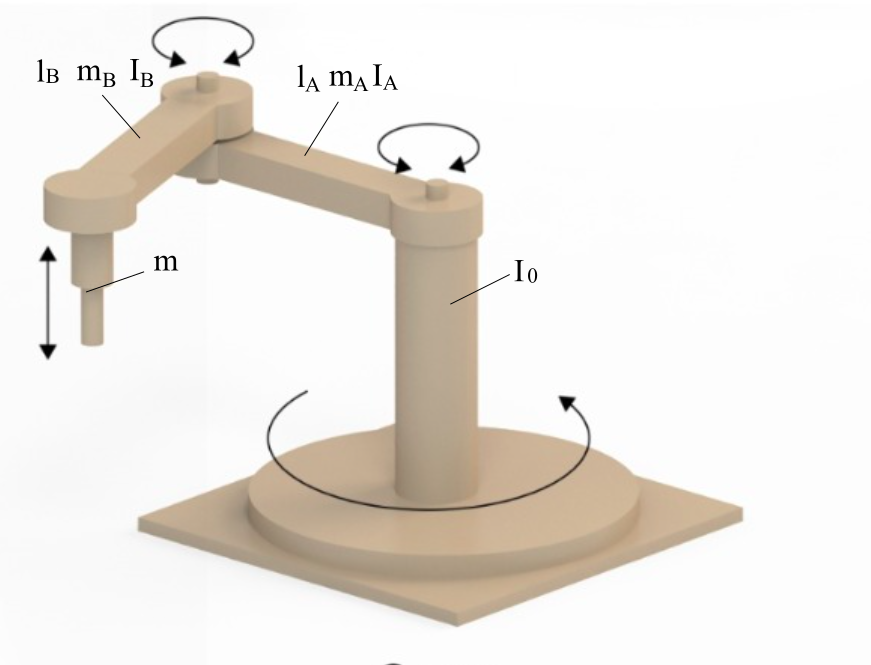

In [2]:
display(Image("bitmap.png"))


# Lagranžijan

$$\mathcal{L}=T-U$$

Najjednostavniji dio Lagraževe funkcije jest potencijalna energija, njoj doprinosi samo translacija vrha robota:

$$U = -mg q$$

Kinetičku energiju dekomponiramo na tri dijela $T=T_A + T_B + T_C$
$$T_C = \frac{m}{2}\dot{q}^2$$
$$T_B = \frac{I_B^{'}\dot{\phi_2}^2}{2} + \frac{m}{2}(\dot{\phi_2 }l_B)^2 $$
$$
T_A = \frac{I_0 \dot{\phi_1}^2}{2} + \frac{I_A^{''} \dot{\phi_1}^2}{2} + \frac{I_B^{''} \dot{\phi_1}^2}{2} + \frac{m \rho^2 \dot{\phi_1}^2}{2}
$$

$I_B^{'}$, $I_B^{''}$, $I_A^{''}$ su tromosti pomaknute u osi rotacije koje leže na zglobovima robotske ruke.
$$I_B^{'} = I_B + M_B r_B^2$$
$$I_B^{''}= I_B + M_B d^2$$
$$
I_A^{''} = I_A +  M_A r_A^2$$
Oznake $d$ i $\rho$ su udaljenosti težišta grede $B$ i vrha skale od osi rotacije $\phi_1$, njih dobivamo ko kosinusovom poučku.
$$
d^2 = l_A^2 + r_B^2 - 2l_A r_B \cos(\phi_2)
$$
$$
\rho^2 = l_A^2 + l_B^2 - 2l_A l_B \cos(\phi_2)
$$
Lagranževe jednadžbe gibanja dobivamo korištenjem simboličke diferencijalcije uz paket $\texttt{sympy}$.


In [3]:
t,g = sp.symbols(r"t,g")

# Parametri Scara stroja
la,lb,ra,rb = sp.symbols(r"L_A,L_B,r_A,r_B")
ma,mb,m,I0,Ia,Ib = sp.symbols(r"m_A, m_B,m I_0,I_A, I_B")


#Generalizirane koordinate
phi1,phi2,q = sp.symbols(r"\phi_1, \phi_2, q",cls =sp.Function)
phi1 = phi1(t)
phi2 = phi2(t)
q = q(t)


#Vremenske derivacije
dphi1 = sp.diff(phi1,t)
d2phi1 = sp.diff(dphi1,t)
dphi2 = sp.diff(phi2,t)
d2phi2 = sp.diff(dphi2,t)
dq = sp.diff(q,t)
d2q = sp.diff(dq,t)

#Udaljenosti od osi rotacija
d2 = la**2 + rb**2 - la*rb*sp.cos(phi2)
rho2 = la**2 + lb**2 - 2*la*lb*sp.cos(phi2) 

#Pomaktnute tromosti
Ia_ss = Ia + mb*ra**2
Ib_ss = Ib + mb*d2
Ib_s = Ib + mb*rb**2


# Vanjske sile
fq,fphi1,fphi2 = sp.symbols(r"f_q,f_{\phi1}, f_{\phi2}",cls = sp.Function)
fq = fq(t)
fphi1 = fphi1(t)
fphi2 = fphi2(t)

## Lagranžijan -  Smbolički račun

In [4]:
U = -m*g*q

Tc = m*dq**2

Tb = (Ib_s + m*lb**2)*dphi2**2

Ta = (I0 + Ia_ss + Ib_ss *m*rho2)*dphi1**2
T = sp.Rational(1,2)*(Ta + Tb + Tc)

T

m*Derivative(q(t), t)**2/2 + (I_B + L_B**2*m + m_B*r_B**2)*Derivative(\phi_2(t), t)**2/2 + (I_0 + I_A + m*(I_B + m_B*(L_A**2 - L_A*r_B*cos(\phi_2(t)) + r_B**2))*(L_A**2 - 2*L_A*L_B*cos(\phi_2(t)) + L_B**2) + m_B*r_A**2)*Derivative(\phi_1(t), t)**2/2

In [5]:
L = T-U
L

g*m*q(t) + m*Derivative(q(t), t)**2/2 + (I_B + L_B**2*m + m_B*r_B**2)*Derivative(\phi_2(t), t)**2/2 + (I_0 + I_A + m*(I_B + m_B*(L_A**2 - L_A*r_B*cos(\phi_2(t)) + r_B**2))*(L_A**2 - 2*L_A*L_B*cos(\phi_2(t)) + L_B**2) + m_B*r_A**2)*Derivative(\phi_1(t), t)**2/2

## Jednadžbe gibanja
Varijacijom Lagranževe funckije dobivamo tri jednadžbe gibanja
$$ \frac{\partial \mathcal{L}}{\partial\phi_1}-\frac{d\partial \mathcal{L}}{dt\partial \dot{\phi_1}}  = -f_{\phi_1}(t) \qquad (1)$$

$$\frac{\partial \mathcal{L}}{\partial\phi_2}-\frac{d\partial \mathcal{L}}{dt\partial \dot{\phi_2}} = -f_{\phi_2}(t) \qquad (2)$$

$$\frac{\partial \mathcal{L}}{\partial q}-\frac{d\partial \mathcal{L}}{dt\partial \dot{q}}  = -f_q(t) \quad\qquad (3) $$


Simboli  $f_q$, $f_{\phi_1}$ i $f_{\phi_2}$ označavaju generalizirane sile i momente.

In [6]:
# Jednadžba (1)
eq1 = (sp.diff(L,phi1) - sp.diff( sp.diff(L,dphi1), t ) + fphi1).simplify()
eq1

-L_A*m*(2*I_B*L_B + 2*L_A**2*L_B*m_B + L_A**2*m_B*r_B - 4*L_A*L_B*m_B*r_B*cos(\phi_2(t)) + L_B**2*m_B*r_B + 2*L_B*m_B*r_B**2)*sin(\phi_2(t))*Derivative(\phi_1(t), t)*Derivative(\phi_2(t), t) - (I_0 + I_A + m*(I_B + m_B*(L_A**2 - L_A*r_B*cos(\phi_2(t)) + r_B**2))*(L_A**2 - 2*L_A*L_B*cos(\phi_2(t)) + L_B**2) + m_B*r_A**2)*Derivative(\phi_1(t), (t, 2)) + f_{\phi1}(t)

In [7]:
# Jednadžba (2)
eq2 = (sp.diff(L,phi2) - sp.diff( sp.diff(L,dphi2), t ) + fphi2).simplify()
eq2

L_A*m*(2*I_B*L_B + 2*L_A**2*L_B*m_B + L_A**2*m_B*r_B - 4*L_A*L_B*m_B*r_B*cos(\phi_2(t)) + L_B**2*m_B*r_B + 2*L_B*m_B*r_B**2)*sin(\phi_2(t))*Derivative(\phi_1(t), t)**2/2 - (I_B + L_B**2*m + m_B*r_B**2)*Derivative(\phi_2(t), (t, 2)) + f_{\phi2}(t)

In [8]:
# Jednadžba (3)
eq3 = (sp.diff(L,q) - sp.diff( sp.diff(L,dq), t ) + fq).simplify()
eq3

g*m - m*Derivative(q(t), (t, 2)) + f_q(t)

In [9]:
# Iz Lagraževih jednadćbi izražavamo druge derivacije generaliziranih koordinata
solutions = sp.solve([eq1,eq2,eq3], (d2phi1,d2phi2,d2q),simiplify = True,rational = False)

### Druge derivacije generaliziranih koordinata su sadržane unutar $\texttt{solutions}$ riječnika

Recimo $\ddot{\phi_2}$ dobivamo:

In [10]:
solutions[d2phi2]

2*I_B*L_A*L_B*m*sin(\phi_2(t))*Derivative(\phi_1(t), t)**2/(2*I_B + 2*L_B**2*m + 2*m_B*r_B**2) + 2*L_A**3*L_B*m*m_B*sin(\phi_2(t))*Derivative(\phi_1(t), t)**2/(2*I_B + 2*L_B**2*m + 2*m_B*r_B**2) + L_A**3*m*m_B*r_B*sin(\phi_2(t))*Derivative(\phi_1(t), t)**2/(2*I_B + 2*L_B**2*m + 2*m_B*r_B**2) - 4*L_A**2*L_B*m*m_B*r_B*sin(\phi_2(t))*cos(\phi_2(t))*Derivative(\phi_1(t), t)**2/(2*I_B + 2*L_B**2*m + 2*m_B*r_B**2) + L_A*L_B**2*m*m_B*r_B*sin(\phi_2(t))*Derivative(\phi_1(t), t)**2/(2*I_B + 2*L_B**2*m + 2*m_B*r_B**2) + 2*L_A*L_B*m*m_B*r_B**2*sin(\phi_2(t))*Derivative(\phi_1(t), t)**2/(2*I_B + 2*L_B**2*m + 2*m_B*r_B**2) + 2*f_{\phi2}(t)/(2*I_B + 2*L_B**2*m + 2*m_B*r_B**2)

In [11]:
solutions[d2q]


(g*m + f_q(t))/m

Iz jednadžbi gibanja možemo pronaći vremenski ovisne generalizirane sile $f_q,f_{\phi_1},f_{\phi_2}$.

In [12]:
forces = sp.solve([eq1,eq2,eq3], (fq,fphi1,fphi2),simiplify = True,rational = False)
forces[fq]

-g*m + m*Derivative(q(t), (t, 2))

## Konverzija simboličkih izraza u numeričke funkcije
Korištenjem metode $\texttt{sympy.lamdify}$ možemo simbolički dobivene izraze drugih derivacija i sila pretvoriti u numeričke funkcije, koijma pružamo parametre sustava kao ulaz. 

In [13]:
#druge derivacije
d2q_num= sp.lambdify((g,m,fq),solutions[d2q])

d2phi1_num = sp.lambdify((t,
    phi2,dphi2,q,dq,phi1,dphi1,
    g,I0,Ia,Ib,ma,
    mb,la,lb,ra,rb,m,fq,fphi1,fphi2), solutions[d2phi1])

d2phi2_num= sp.lambdify((t,
    phi2,dphi2,q,dq,phi1,dphi1,
    g,I0,Ia,Ib,ma,
    mb,la,lb,ra,rb,m,fq,fphi1,fphi2),solutions[d2phi2])
    
#sile
fq_num = sp.lambdify((t,g,m,d2q),forces[fq])

fphi1_num = sp.lambdify((
    t,phi2,dphi2,d2phi2,q,dq,
    d2q,phi1,dphi1,d2phi1,
    g,I0,Ia,Ib,ma,
    mb,la,lb,ra,rb,m),
    forces[fphi1])

fphi2_num = sp.lambdify((
    t,phi2,dphi2,d2phi2,q,dq,
    d2q,phi1,dphi1,d2phi1,
    g,I0,Ia,Ib,ma,mb,la,lb,ra,rb,m),
    forces[fphi2])

## Numeričko integriranje jednadžbi gibanja

In [14]:
d2q_num= sp.lambdify((g,m,fq),solutions[d2q])
d2phi1_num = sp.lambdify((t,
    phi2,dphi2,q,dq,phi1,dphi1,
    g,I0,Ia,Ib,ma,
    mb,la,lb,ra,rb,m,fq,fphi1,fphi2), solutions[d2phi1])
d2phi2_num= sp.lambdify((t,
    phi2,dphi2,q,dq,phi1,dphi1,
    g,I0,Ia,Ib,ma,
    mb,la,lb,ra,rb,m,fq,fphi1,fphi2),solutions[d2phi2])

def Fq(t):
    return 1
def Fphi1(t):
    return 1
def Fphi2(t):
    return 1

In [15]:
def diff_eq(t,state):
      
    phi1=state[0]
    dphi1=state[1]
    phi2=state[2]
    dphi2=state[3]
    q=state[4]
    dq=state[5]
   
    FPHI2=Fphi2(t)
    FPHI1=Fphi1(t)
    FQ=Fq(t)
    d2q_=d2q_num(9.81,1,FQ)
    
    d2phi1_=d2phi1_num(t,
    phi2,dphi2,q,dq,phi1,dphi1,
    9.81,0.5,1.2,1,0.5,
    0.5,1.2,1,0.6,0.5,1,FQ,FPHI1,FPHI2)
    
    d2phi2_=d2phi2_num(t,
    phi2,dphi2,q,dq,phi1,dphi1,
    9.81,0.5,1.2,1,0.5,
    0.5,1.2,1,0.6,0.5,1,FQ,FPHI1,FPHI2)
   
    return [dphi1,d2phi1_,dphi2,d2phi2_,dq,d2q_]
    



In [16]:
state0 = np.zeros(6)
Tmax = 10
t=np.arange(0,Tmax,1e-2)


sol = solve_ivp(diff_eq,(0,Tmax),state0,t_eval=t)

Text(0.5, 1.0, '$q$')

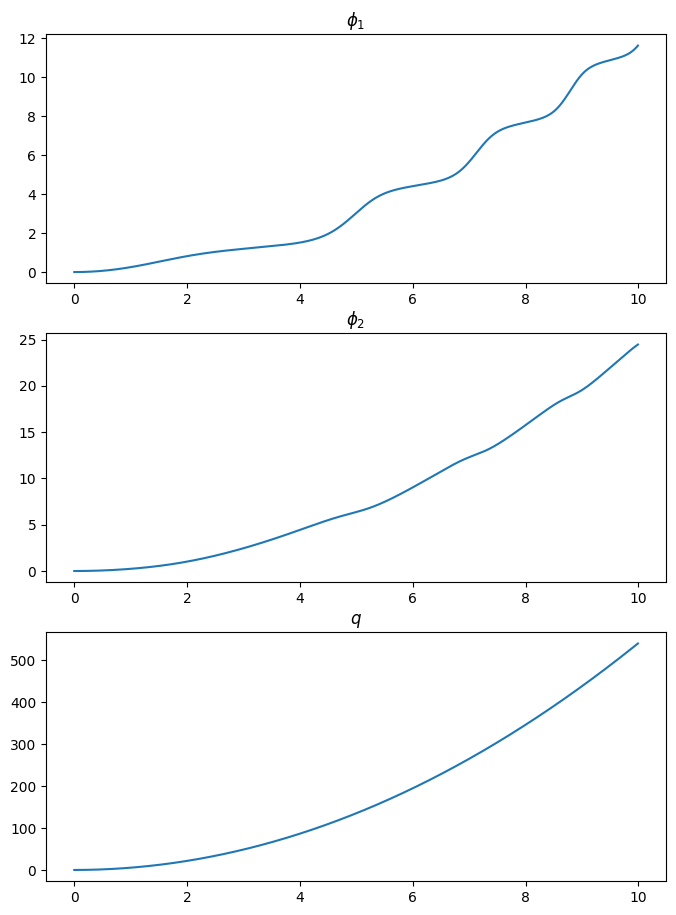

In [17]:
phi1_plot=sol.y[0,:]
phi2_plot=sol.y[2,:]
q_plot=sol.y[4,:]

fig,ax = plt.subplots(3,1,figsize=(8,11))

ax[0].plot(t,phi1_plot)
ax[0].set_title(r"$\phi_1$")
ax[1].plot(t,phi2_plot)
ax[1].set_title(r"$\phi_2$")
ax[2].plot(t,q_plot)
ax[2].set_title(r"$q$")



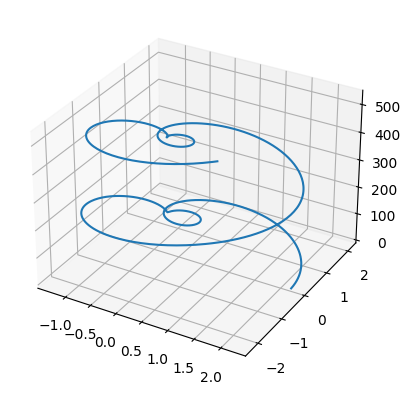

In [18]:
r1 = np.array([1.2*np.cos(phi1_plot),1.2*np.sin(phi1_plot)])
r2 = np.array([1*np.cos(phi2_plot),1*np.sin(phi2_plot)])
r = r1+r2
fig,ax = plt.subplots(subplot_kw = {"projection": "3d"})
ax.plot(r[0,:],r[1,:],q_plot)

## Generalizirane sile:
Ukoliko rješavamo problem inverzne kinematike, zadajemo trajektoriju kojom se robot treba gibati, odnosno definiramo:
$$
q(t),\dot{q(t)},\ddot{q(t)}
$$
$$
\phi_1(t),\dot{\phi_1(t)},\ddot{\phi_1}(t)
$$
$$
q(t),\dot{q(t)},\ddot{q}(t)
$$


### Parametri SCAR-a robota

In [19]:
la=1.2
lb=1
ra=la/2
rb=lb/2
m=1
ma=0.5
mb=0.5
Ia=1.2
I0=0.5
Ib=1
g=9.81


In [20]:
def get_fphi1(t,phi2,dphi2,d2phi2,q,dq,
    d2q,phi1,dphi1,d2phi1,
    g=9.81,I0=I0,Ia=Ia,Ib=Ib,ma=ma,
    mb=mb,la=la,lb=lb,ra=ra,rb=rb,m=m
    ):
    return fphi1_num(t,phi2,dphi2,d2phi2,q,dq,
    d2q,phi1,dphi1,d2phi1,
    g,I0,Ia,Ib,ma,
    mb,la,lb,ra,rb,m)
def get_fq (t,d2q,g=9.81,m=m):
    
    return fq_num(t,g,m,d2q) 

def get_fphi2(t,phi2,dphi2,d2phi2,q,dq,
    d2q,phi1,dphi1,d2phi1,
    g=9.81,I0=I0,Ia=Ia,Ib=Ib,ma=ma,
    mb=mb,la=la,lb=lb,ra=ra,rb=rb,m=m):
    
    return fphi2_num(t,phi2,dphi2,d2phi2,q,dq,
    d2q,phi1,dphi1,d2phi1,
    g,I0,Ia,Ib,ma,
    mb,la,lb,ra,rb,m) 

## Generalizirane koordinate, brzine i akceleracije

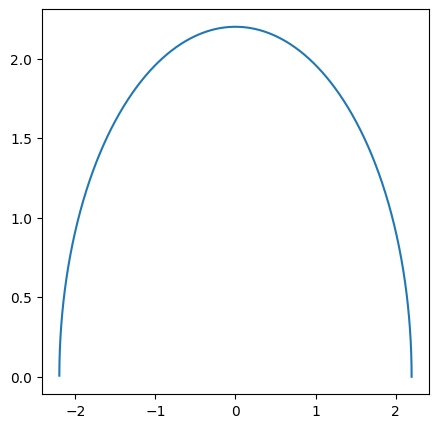

In [21]:
T=10
om = 0.5*np.pi*2/T
t = np.arange(0,T,1e-2)


phi1_ = om*t
dphi1_=om*np.ones_like(t)
d2phi1_=np.zeros_like(t)

phi2_ = om*t
dphi2_=om*np.ones_like(t)
d2phi2_=np.zeros_like(t)

r1 = np.array([la*np.cos(phi1_),la*np.sin(phi1_)])
r2 = np.array([lb*np.cos(phi2_),lb*np.sin(phi2_)])
r = r1+r2

q_t =1- np.cos(om*t)
dq_t=om*np.sin(om*t)
d2q_t=om**2*np.cos(om*t)


fig,ax = plt.subplots(1,1,figsize=(5,5))

ax.plot(r[0,:],r[1,:])



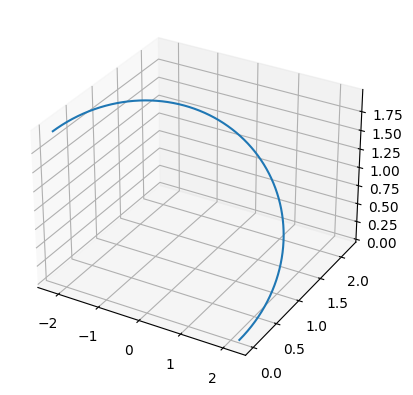

In [22]:
fig,ax = plt.subplots(subplot_kw = {"projection": "3d"})
ax.plot(r[0,:],r[1,:],q_t)

In [23]:
MOMA=get_fphi1(t,phi2_,dphi2_,d2phi2_,q_t,dq_t,
    d2q_t,phi1_,dphi1_,d2phi1_,)


In [24]:
Fq=get_fq(t,d2q_t)

In [25]:
MOMB=get_fphi2(t,phi2_,dphi2_,d2phi2_,q_t,dq_t,
    d2q_t,phi1_,dphi1_,d2phi1_,)

Text(0.5, 1.0, 'Moment oko zgloba B [a.u.]')

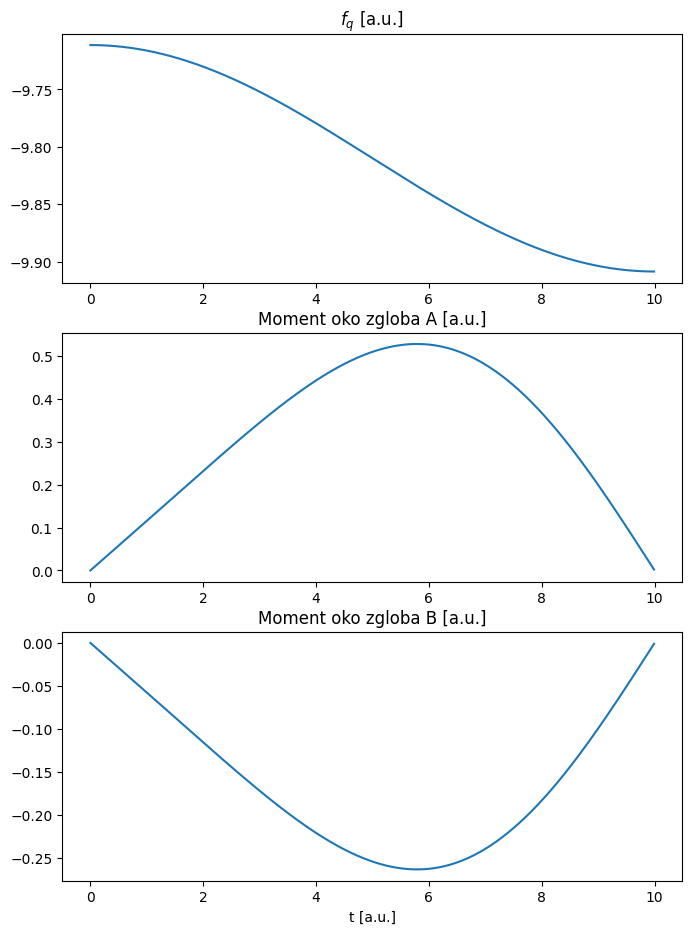

In [26]:
fig,ax = plt.subplots(3,1,figsize=(8,11))

ax[0].plot(t,Fq,label = r"$f_q$")
ax[0].set_title(r"$f_q$ [a.u.]")
ax[2].set_xlabel("t [a.u.]")
ax[1].plot(t,MOMA,label=r"$M_A$")
ax[1].set_title(r"Moment oko zgloba A [a.u.]")
ax[2].plot(t,MOMB,label=r"$M_B$")
ax[2].set_title(r"Moment oko zgloba B [a.u.]")

